In [1]:
import os, sys
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.pyplot import *
%matplotlib inline

Constructing sky...
Constructing visibilities...
Constructing maximum likelihood sky...
Entering for loop...
For loop finished...


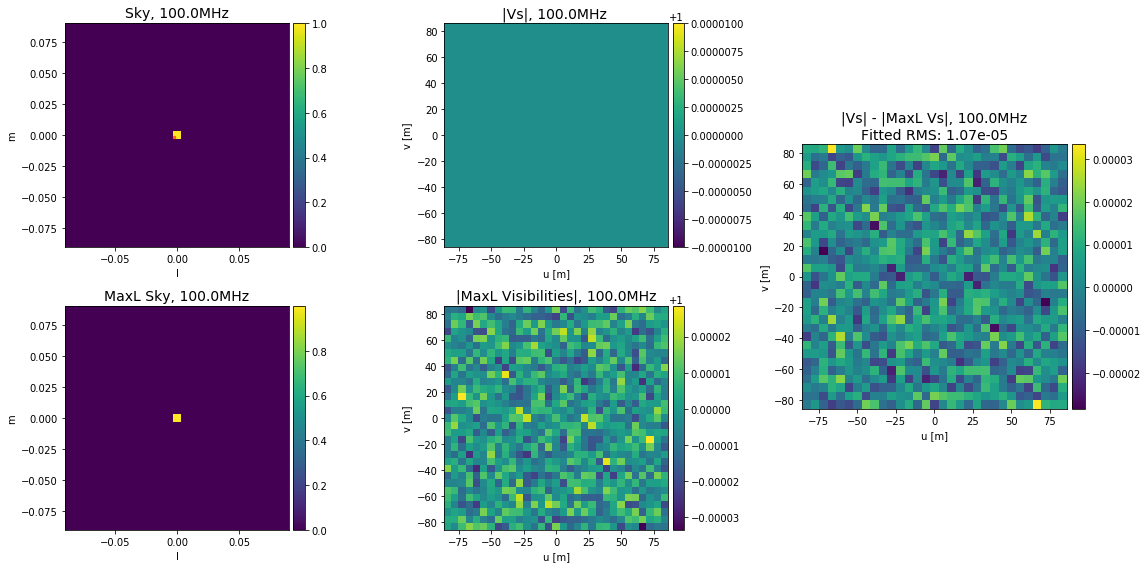

In [5]:
%run construct_maximum_likelihood_sky.py --freq=100 --zenith_source --grid_pos

In [ ]:
%run construct_maximum_likelihood_sky.py --freq=100 --horizon_source

In [ ]:
%run construct_maximum_likelihood_sky.py --freq=100 --m_offset=0.5 --l_offset=-0.25

---

#### Compute fitted RMS as source walked to edge of image using nearest pixel center as source location

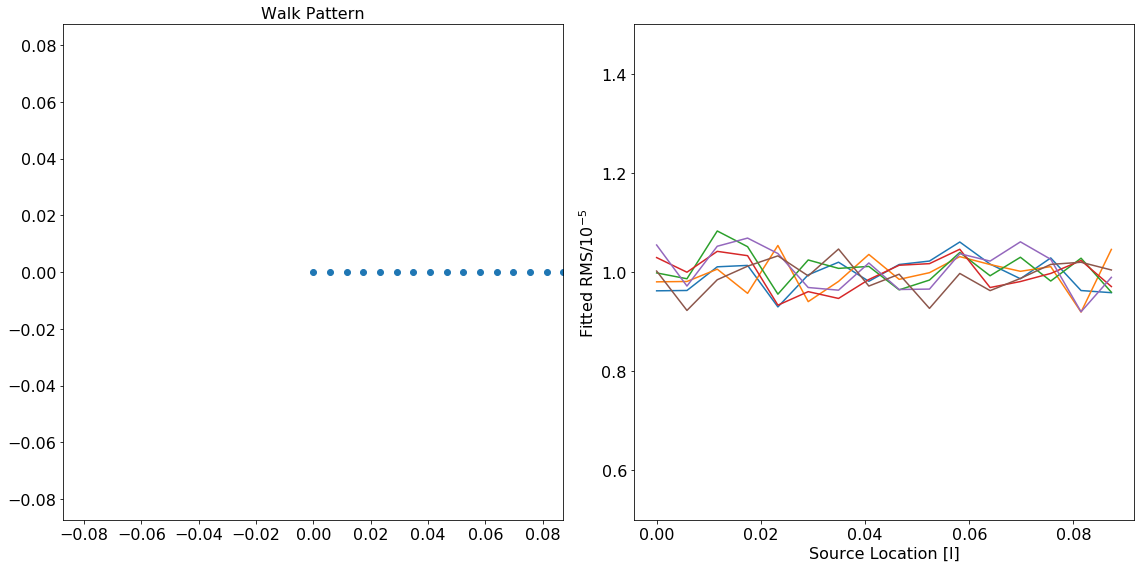

In [13]:
%run plot_fitted_rms_vs_angular_offset.py --freq=100-110 --freq_res=2.0

---

To do 5/10:  
  - 40 degree field of view (16x more pixels)
    - 5/14: Need to do this on Oscar, takes too long on local machine
  - Look at using a random set of floating point locations between l = 0 and l = 5 deg
  - Look at multiple frequencies X
  - Look at beam
    - Use Nicolas beams to generate visibilities (https://github.com/HERA-Team/HERA-Beams/tree/master/NicolasFagnoniBeams)
    - Fit Gaussian to beam as the approximate model for the maximum likelihood solution beam
  - Look at frequency dependent UV coverage

------

#### Add multiple sources

In [ ]:
%run construct_maximum_likelihood_sky.py --freq=100 --nsources=400 --grid_pos

---

Look at histogram of residuals to see that the distribution is approximately Gaussian with std dev = RMS input (1e-5)

In [ ]:
from scipy.optimize import curve_fit

def Gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
figure(figsize=(16,9))

counts, bins, patches = hist(diff_data[0].flatten(), bins=50)
xlabel('|Vs| - |Max Likelihood Vs|, %.1fMHz' %freqs[freq_ind], size=16)
ylabel('Counts', size=16)

bin_width = np.mean(np.diff(bins))
fit_xs = bins[:-1] + bin_width/2
guess_params = [np.max(counts), 0.0, opts.rms]
fit_params, fit_cov = curve_fit(Gaussian, fit_xs, counts, p0=guess_params)
# 0: amplitude, 1: mean, 2:std dev
gauss_fit = Gaussian(fit_xs, fit_params[0], fit_params[1], fit_params[2])
plot(fit_xs, gauss_fit, 'k--', lw=2)
title('Standard Deviation = %.3e' %fit_params[-1])
gca().tick_params(axis='both', labelsize=16)

---

To do (4/25):
 - Make sure symmetry preserved if I add complex noise (add conjugate of complex noise to (-u, -v)) X
 - Look at source at edge of bottom most pixel X
     - Look at walking along constant m with
     - Also make the plot of fitted RMS/input RMS as you walk along pixel centers from (l, m) = (0, 0) X
 - See if shifting a source to a nearest pixel center produces the correct RMS when fit
     - Maybe already accounted for?
     - I think this is already accounted for (5/9)
 - Put in lots of sources X
 - Look at the solution for realistic uv coverage and a beam
     - Add the frequency axis back in

---

# Extra plots

### Log scale toggle plotting

In [ ]:
log_scale = False
freq_ind = 0
extent_uv = [us_grid.min(), us_grid.max(), vs_grid.min(), vs_grid.max()]
extent_lm = [ls.min(), ls.max(), ms.min(), ms.max()]

fig = figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 3)


# Plot sky
skyax = fig.add_subplot(gs[0,0])
if log_scale:
    skyim = skyax.imshow(np.log10(Sky[freq_ind]), interpolation='nearest', extent=extent_lm)
    skyax.set_title('Log Sky, %.1fMHz' %freqs[freq_ind])
else:
    skyim = skyax.imshow(Sky[freq_ind], interpolation='nearest', extent=extent_lm)
    skyax.set_title('Sky, %.1fMHz' %freqs[freq_ind])
skyax.set_xlabel('l')
skyax.set_ylabel('m')


# Plot visibilities using true source position
visax = fig.add_subplot(gs[0,1])
if np.abs(Vs[freq_ind]).min() == np.abs(Vs[freq_ind]).max():
    if log_scale:
        vmin = np.log10(np.abs(Vs[freq_ind]).min() - 1.e-5)
        vmax = np.log10(np.abs(Vs[freq_ind]).min() + 1.e-5)
    else:
        vmin = np.abs(Vs[freq_ind]).min() - 1.e-5
        vmax = np.abs(Vs[freq_ind]).min() + 1.e-5
else:
    if log_scale:
        vmin = np.log10(np.abs(Vs[freq_ind]).min())
        vmax = np.log10(np.abs(Vs[freq_ind]).max())
    else:
        vmin = np.abs(Vs[freq_ind]).min()
        vmax = np.abs(Vs[freq_ind]).min()
if log_scale:
    visim = visax.imshow(np.log10(np.abs(Vs[freq_ind])), interpolation='nearest', extent=extent_uv, vmin=vmin, vmax=vmax)
    visax.set_title('Log|Vs|, ' + str(freqs[freq_ind]) + 'MHz')
else:
    visim = visax.imshow(np.abs(Vs[freq_ind]), interpolation='nearest', extent=extent_uv, vmin=vmin, vmax=vmax)
    visax.set_title('Vs, ' + str(freqs[freq_ind]) + 'MHz')
visax.set_xlabel('u [m]')
visax.set_ylabel('v [m]')


# Plot sky solution for maximum likelihood
anskyax = fig.add_subplot(gs[1,0])
if log_scale:
    anskyim = anskyax.imshow(np.log10(np.real(a[freq_ind])), interpolation='nearest', extent=extent_lm, origin='lower')
    anskyax.set_title('Log Max Likelihood Sky, %.1fMHz' %freqs[freq_ind])
else:
    anskyim = anskyax.imshow(np.real(a[freq_ind]), interpolation='nearest', extent=extent_lm)
    anskyax.set_title('Maximum Likelihood Sky, %.1fMHz' %freqs[freq_ind])
anskyax.set_xlabel('l')
anskyax.set_ylabel('m')


# Plot visibilities for maximum likelihood solution
anvisax = fig.add_subplot(gs[1,1])
if log_scale:
    anvisim = anvisax.imshow(np.log10(np.abs(Vs_maxl[freq_ind])), interpolation='nearest', extent=extent_uv)
    anvisax.set_title('Log|Max Likelihood Visibilities|, %.1fMHz' %freqs[freq_ind])
else:
    anvisim = anvisax.imshow(np.abs(Vs_maxl[freq_ind]), interpolation='nearest', extent=extent_uv)
    anvisax.set_title('|Max Likelihood Visibilities|, %.1fMHz' %freqs[freq_ind])
anvisax.set_xlabel('u [m]')
anvisax.set_ylabel('v [m]')


# Plot |Vs| - |Vs_maxl|
diff_data = np.abs(Vs) - np.abs(Vs_maxl)
if log_scale:
    diffim = diffax.imshow(np.log10(diff_data[freq_ind]), interpolation='nearest', extent=extent_uv)
    diffax.set_title('Log(|Vs| - |Max Likelihood Vs|), %.1fMHz' %freqs[freq_ind])
else:
    diffax = fig.add_subplot(gs[:, -1])
    diffim = diffax.imshow(diff_data[freq_ind], interpolation='nearest', extent=extent_uv)
diffax.set_title('|Vs| - |Max Likelihood Vs|, %.1fMHz' %freqs[freq_ind])
diffax.set_xlabel('u [m]')
diffax.set_ylabel('v [m]')


# imgs = [skyim, visim, ftvisim, anskyim, anvisim, anftvisim]
imgs = [skyim, visim, anskyim, anvisim, diffim]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

#### Log scale plotting

In [ ]:
freq_ind = 0
extent_uv = [us_grid.min(), us_grid.max(), vs_grid.min(), vs_grid.max()]
extent_lm = [ls.min(), ls.max(), ms.min(), ms.max()]

fig = figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 3)


# Plot sky
skyax = fig.add_subplot(gs[0,0])
skyim = skyax.imshow(np.log10(Sky[freq_ind]), interpolation='nearest', extent=extent_lm)
skyax.set_title('Log Sky, %.1fMHz' %freqs[freq_ind])
skyax.set_xlabel('l')
skyax.set_ylabel('m')

# Plot visibilities using true source position
visax = fig.add_subplot(gs[0,1])
if np.abs(Vs[freq_ind]).min() == np.abs(Vs[freq_ind]).max():
    vmin = np.log10(np.abs(Vs[freq_ind]).min() - 1.e-5)
    vmax = np.log10(np.abs(Vs[freq_ind]).min() + 1.e-5)
visim = visax.imshow(np.log10(np.abs(Vs[freq_ind])), interpolation='nearest', extent=extent_uv, vmin=vmin, vmax=vmax)
visax.set_title('Log|Vs|, ' + str(freqs[freq_ind]) + 'MHz')
visax.set_xlabel('u [m]')
visax.set_ylabel('v [m]')

# Plot FT visibilities using true source position
# ftvisax = fig.add_subplot(gs[0,2])
# ftvisim = ftvisax.imshow(np.abs(Vs_ft[freq_ind]), interpolation='nearest', extent=extent_uv)
# ftvisax.set_title('|FT(Vs)|, %sMHz' %str(freqs[freq_ind]))
# ftvisax.set_xlabel('u [m]')
# ftvisax.set_ylabel('v [m]')

# Plot sky solution for maximum likelihood
anskyax = fig.add_subplot(gs[1,0])
anskyim = anskyax.imshow(np.log10(np.real(a[freq_ind])), interpolation='nearest', extent=extent_lm, origin='lower')
anskyax.set_title('Log Max Likelihood Sky, %.1fMHz' %freqs[freq_ind])
anskyax.set_xlabel('l')
anskyax.set_ylabel('m')

# Plot visibilities for maximum likelihood solution
anvisax = fig.add_subplot(gs[1,1])
anvisim = anvisax.imshow(np.log10(np.abs(Vs_maxl[freq_ind])), interpolation='nearest', extent=extent_uv)
anvisax.set_title('Log|Max Likelihood Visibilities|, %.1fMHz' %freqs[freq_ind])
anvisax.set_xlabel('u [m]')
anvisax.set_ylabel('v [m]')

# Plot FT visibilities for maximum likelihood solution
# anftvisax = fig.add_subplot(gs[1,2])
# anftvisim = anftvisax.imshow(np.abs(Vs_aft[freq_ind]), interpolation='nearest', extent=extent_uv)
# anftvisax.set_title('|FT(Maximum Likelihood Visibilities)|, %.1fMHz' %freqs[freq_ind])
# anftvisax.set_xlabel('u [m]')
# anftvisax.set_ylabel('v [m]')

# Plot |Vs| - |Vs_maxl|
diff_data = np.abs(Vs) - np.abs(Vs_maxl)
diffax = fig.add_subplot(gs[:, -1])
diffim = diffax.imshow(np.log10(diff_data[freq_ind]), interpolation='nearest', extent=extent_uv)
diffax.set_title('Log(|Vs| - |Max Likelihood Vs|), %.1fMHz' %freqs[freq_ind])
diffax.set_xlabel('u [m]')
diffax.set_ylabel('v [m]')

# imgs = [skyim, visim, ftvisim, anskyim, anvisim, anftvisim]
imgs = [skyim, visim, anskyim, anvisim, diffim]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

#### Plot visibilities generated using the anlytic solution and true source positions

In [ ]:
freq_ind = 0
extent_uv = [us_grid.min(), us_grid.max(), vs_grid.min(), vs_grid.max()]
extent_lm = [ls.min(), ls.max(), ms.min(), ms.max()]
 
fig = figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2)

mskyax = fig.add_subplot(gs[0])
mskyim = mskyax.imshow(np.real(a[freq_ind]), extent=extent_lm)
mskyax.set_title('Real( Max L Sky ), %.1fMHz' %freqs[freq_ind])
mskyax.set_xlabel('l')
mskyax.set_ylabel('m')

iskyax = fig.add_subplot(gs[1])
iskyim = iskyax.imshow(np.imag(a[freq_ind]), extent=extent_lm)
iskyax.set_title('Imag( Max L Sky ), %.1fMHz' %freqs[freq_ind])
iskyax.set_xlabel('l')
iskyax.set_ylabel('m')

imgs = [mskyim, iskyim]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

In [ ]:
right = np.dot(np.dot(DFT.conj().T, N_inv), d[0].flatten()).reshape((npix_side, npix_side))
left = np.linalg.inv(np.dot(np.dot(DFT.conj().T, N_inv), DFT))

fig = figure(figsize=(12,10))
gs = gridspec.GridSpec(2,2)

ax1 = subplot(gs[0, 0])
realim = ax1.imshow(np.real(right), interpolation='nearest', extent=extent_uv)
ax1.set_title(r'$\Re(F^\dagger N^{-1} d)$', size=16)

ax2 = subplot(gs[0, 1])
imagim = ax2.imshow(np.imag(right), interpolation='nearest', extent=extent_uv)
ax2.set_title(r'$\Im(F^\dagger N^{-1} d)$', size=16)

ax3 = subplot(gs[1, 0])
realim2 = ax3.imshow(np.real(left), interpolation='nearest', extent=extent_uv)
ax3.set_title(r'$\Re(F^\dagger N^{-1} F)^{-1}$', size=16)

ax4 = subplot(gs[1, 1])
imagim2 = ax4.imshow(np.imag(left), interpolation='nearest', extent=extent_uv)
ax4.set_title(r'$\Im(F^\dagger N^{-1} F)^{-1}$', size=16)

imgs = [realim, imagim, realim2, imagim2]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

Check if phase of d matches phase of Vs

In [ ]:
# imshow(np.real(d[0]), interpolation='nearest')
# colorbar()
# title(r'$\Re(d)$')

fig = figure(figsize=(12,10))
gs = gridspec.GridSpec(2,2)

ax1 = subplot(gs[0, 0])
realim = ax1.imshow(np.real(d[0]), interpolation='nearest', extent=extent_uv)
ax1.set_title(r'$\Re(d)$', size=16)

ax2 = subplot(gs[0, 1])
imagim = ax2.imshow(np.imag(d[0]), interpolation='nearest', extent=extent_uv)
ax2.set_title(r'$\Im(d)$', size=16)

ax3 = subplot(gs[1, 0])
realim2 = ax3.imshow(np.real(Vs[0]), interpolation='nearest', extent=extent_uv)
ax3.set_title(r'$\Re(Vs)$', size=16)

ax4 = subplot(gs[1, 1])
imagim2 = ax4.imshow(np.imag(Vs[0]), interpolation='nearest', extent=extent_uv)
ax4.set_title(r'$\Im(Vs)$', size=16)

imgs = [realim, imagim, realim2, imagim2]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

Check what happens when N_inv*d and DFT*d to imaginary part

In [ ]:
Nd = np.dot(N_inv, d[0].flatten()).reshape((npix_side, npix_side))
DFTd = np.dot(DFT.conj().T, d[0].flatten()).reshape((npix_side, npix_side))

fig = figure(figsize=(12,10))
gs = gridspec.GridSpec(2,2)

ax1 = subplot(gs[0, 0])
realim = ax1.imshow(np.real(Nd), interpolation='nearest', extent=extent_uv)
ax1.set_title(r'$\Re(N^{-1} d)$', size=16)

ax2 = subplot(gs[0, 1])
imagim = ax2.imshow(np.imag(Nd), interpolation='nearest', extent=extent_uv)
ax2.set_title(r'$\Im(N^{-1} d)$', size=16)

ax3 = subplot(gs[1, 0])
realim2 = ax3.imshow(np.real(DFTd), interpolation='nearest', extent=extent_uv)
ax3.set_title(r'$\Re(F^\dagger d)$', size=16)

ax4 = subplot(gs[1, 1])
imagim2 = ax4.imshow(np.imag(DFTd), interpolation='nearest', extent=extent_uv)
ax4.set_title(r'$\Im(F^\dagger d)$', size=16)

imgs = [realim, imagim, realim2, imagim2]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)

In [ ]:
imshow(np.abs(d[0]) - np.abs(Vs[0]), interpolation='nearest')
title('|d| - |Vs|', size=16)
colorbar()

figure()
# right = np.dot(np.dot(DFT.conj().T, N_inv), d[0, :].flatten()).reshape((npix_side, npix_side))
# right2 = np.dot(np.dot(DFT.conj().T, N_inv), Vs[0, :].flatten()).reshape((npix_side, npix_side))
right = np.dot(N_inv, d[0].flatten()).reshape((npix_side, npix_side))
right2 = np.dot(N_inv, Vs[0].flatten()).reshape((npix_side, npix_side))
imshow(np.abs(right) - np.abs(right2), interpolation='nearest')
title(r'$\left| N^{-1} d \right| - \left| N^{-1} Vs \right|$', size=16)
colorbar()

In [ ]:
fig = figure(figsize=(16,9))
gs = gridspec.GridSpec(1,4)

i = 0
d_temp = np.copy(Vs)[i].flatten()

ax1 = subplot(gs[0])
im1 = ax1.imshow(np.abs(d_temp.reshape((npix_side, npix_side))), interpolation='nearest', extent=extent_uv)
ax1.set_title(r'$|d|$', size=16)

# Add noise to off diagonals
n = np.random.normal(0, RMS, top_right_inds.size)
d_temp[top_right_inds] += n
d_temp[bottom_left_inds] += n

ax2 = subplot(gs[1])
im2 = ax2.imshow(np.abs(d_temp.reshape((npix_side, npix_side))), interpolation='nearest', extent=extent_uv)
ax2.set_title(r'$|d| + offdiag$', size=16)
ax2.scatter(us_vec[top_right_inds], vs_vec[top_right_inds], c='r', marker='.')
ax2.scatter(us_vec[bottom_left_inds], vs_vec[bottom_left_inds], c='r', marker='.')
print d_temp[diag_inds].min(), d_temp[diag_inds].max()

# Add noise to diagonal
n = np.random.normal(0, RMS, diag_inds.size)
d_temp[diag_inds] += n
print d_temp[center_ind]

ax3 = subplot(gs[2])
im3 = ax3.imshow(np.abs(d_temp.reshape((npix_side, npix_side))), interpolation='nearest', extent=extent_uv)
ax3.set_title(r'$|d| + offdiag + diag$', size=16)

# Add noise to central pixel
n = np.random.normal(0, RMS, center_ind.size)
d_temp[center_ind] += n
print d_temp[center_ind]
print d_temp[diag_inds].min(), d_temp[diag_inds].max()

ax4 = subplot(gs[3])
im4 = ax4.imshow(np.abs(d_temp.reshape((npix_side, npix_side))), interpolation='nearest', extent=extent_uv)
ax4.set_title(r'$|d| + offdiag + diag + center$')

imgs = [im1, im2, im3, im4]

for i,ax in enumerate(fig.axes):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(imgs[i], cax=cax)

gs.tight_layout(fig)